In [190]:
%matplotlib inline

In [137]:
from skimage.io import collection, imread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import glob

from datetime import datetime
import nltk

# How is the public opinion about a company correlated to it's market value?

A company's market value is variable and depends on a lot of factors. The price is a reflection of the company's perceived value - what the public is willing to pay for a piece of the company. It can and will rise and fall, based on a variety of factors in the global landscape and within the company itself. One of which is becoming more influential than ever - people's opinion on social media.

To analyze this correlation we'll look at two datasets. The first one contains over 3 million unique tweets with their information such as tweet id, author of the tweet, post date, the text body of the tweet, and the number of comments, likes, and retweets of tweets matched with the related company.

The second one will just have daily stock price records (from the Forbes2000) for us to make a reference with.

### 1. Data Acquisition 

So first let's read the tweets dataset into pandas and inspect a small sample from the two dataframes.

In [138]:
tweets = pd.read_csv('./top-companies-tweets/Tweet.csv')
tweets.sample(5)

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
64725,562666962820804608,duttasanjib,1422985232,#LendingClub Adds #Tech-Firm #Cred With #Aliba...,0,0,1
1352758,779023777136992256,App_sw_,1474568716,#Microsoft cuts jobs locally and abroad. Read ...,0,0,0
1057006,735137926053400577,It_c0nsulting,1464105514,MarTech Today: Adobe's Marketing Cloud goes VR...,0,0,0
1712462,841314950438092802,zerofiltertruth,1489420089,- I love product & see incred fit of $P with $...,2,0,0
1570402,815474913951641600,It_c0nsulting,1483259344,#Google Assistant vs. Siri: Which is the Best ...,0,0,0


In [139]:
tweets_company = pd.read_csv('./top-companies-tweets/Company_Tweet.csv')
tweets_company.sample(5)

,tweet_id,ticker_symbol
399994,697766652960755712,AAPL
1859856,621771236289474560,GOOGL
2025143,968127871008075776,GOOGL
4236311,1173944494275911680,TSLA
3522153,875834102926245888,TSLA


So next up let's read the datasets for each of the stocks, which we are monitoring. We will save them in a dictionary with the key, being the company's tick name and the value - it's stock prices over time dataset.

In [140]:
stocks_df = {}
for name in glob.glob('./stocks/*'):
    stocks_df[name.split('\\')[-1].split('.')[0]] = pd.read_csv(name)
stocks = pd.concat(stocks_df)
stocks.sample(10)

Date         Low        Open      Volume        High  \
AAPL 7830  23-12-2011   14.267500   14.274643   269399200   14.413929   
     6379  23-03-2006    2.128929    2.207857  1427826400    2.210714   
     9254  23-08-2017   39.720001   39.767502    77596400   40.117500   
GOOG 2160  20-03-2013  404.204956  406.889862     2938573  407.228607   
TSLA 231   27-05-2011    5.764000    5.908000     8435500    5.934000   
AAPL 3608  22-03-1995    0.323661    0.323661   479147200    0.352679   
GOOG 99    10-01-2005   95.556831   96.886841    15135721   98.680122   
AAPL 8038  22-10-2012   21.812857   21.872143   546730800   22.692142   
TSLA 1663  06-02-2017   50.125999   50.200001    17812500   51.563999   
     755   28-06-2013   21.341999   21.714001    28743000   21.888000   

                Close  Adjusted Close  
AAPL 7830   14.404643       12.386595  
     6379    2.148571        1.847562  
     9254   39.994999       38.227753  
GOOG 2160  405.833832      405.833832  
TSLA 231     5.910000        5.910000  
AAPL 3608    0.339844        0.289729  
GOOG 99     97.165802       97.165802  
AAPL 8038   22.643929       19.555180  
TSLA 1663   51.554001       51.554001  
     755    21.472000       21.472000

### 2. Data Tidying and Cleaning

First let's combine the two tables from the twitter dataset, convert the dates to a datetime object and rename the column.

In [141]:
tweets = pd.merge(tweets, tweets_company, on = "tweet_id")

In [142]:
tweets["date"] = pd.to_datetime(tweets.post_date, unit='s')
tweets = tweets.drop(columns="post_date")
tweets.sample(5)


,tweet_id,writer,body,comment_num,retweet_num,like_num,ticker_symbol,date
137788,571312245981868032,FalconGlobalLLC,2/27/2015 Today’s Day Trade Zones Posted #Emin...,0,0,0,AMZN,2015-02-27 14:13:48
541269,629300712615317504,stockwire24,http://Amazon.com Prime Now Available In Birmi...,0,0,0,AMZN,2015-08-06 14:39:16
22039,555043538380271616,_abhayshah,.@delray -Aren't all big boxes guilty of this?...,0,0,0,AMZN,2015-01-13 16:47:46
381354,606951194536361985,stockprincess,Learn from your trading mistakes $GOOG $PCLN $...,0,0,0,AAPL,2015-06-05 22:30:16
4084088,1171031304986603522,sbalatan,$TSLA - Tesla’s brand is deteriorating really ...,0,0,3,TSLA,2019-09-09 12:03:14


We will see what timeframe does our dataset cover, by getting the data of the earliest and latest tweets.

In [143]:
tweets.date.min(), tweets.date.max()

(Timestamp('2015-01-01 00:00:57'), Timestamp('2019-12-31 23:55:53'))

So it has data from 01.01.2015 to 31.12.2019, so basically from 2015 to the beginning of 2020. Knowing this we can filter out the stock prices to be only in this period of time. But first we have to covert the "Date" column to datetime.

In [144]:
def string_to_date(date_string):
    return datetime.strptime(date_string, "%d-%m-%Y")
stocks.Date = pd.to_datetime(stocks.Date.apply(string_to_date))

In [145]:
stocks = stocks[(stocks.Date >= '01-01-2015') & (stocks.Date < '01-01-2020')]
stocks.sample(10)

Date          Low         Open     Volume         High  \
AAPL 9698 2019-05-31    43.747501    44.057499  108174400    44.497501   
MSFT 7958 2017-10-05    74.959999    75.220001   21195300    76.120003   
TSLA 1248 2015-06-15    49.202000    49.939999   10931000    50.256001   
AMZN 5173 2017-12-04  1128.000000  1173.849976    5931900  1175.199951   
GOOG 3120 2017-01-10   803.510010   807.859985    1176800   809.130005   
     3036 2016-09-09   759.659973   770.099976    1885500   773.244995   
TSLA 2167 2019-02-07    60.599998    62.660000   32603000    62.939999   
MSFT 7365 2015-06-01    46.619999    47.060001   28837300    47.770000   
     7770 2017-01-06    62.040001    62.299999   19922900    63.150002   
GOOG 3220 2017-06-05   975.099976   976.549988    1252100   986.909973   

                 Close  Adjusted Close  
AAPL 9698    43.767502       42.961842  
MSFT 7958    75.970001       72.120842  
TSLA 1248    50.076000       50.076000  
AMZN 5173  1133.949951     1133.949951  
GOOG 3120   804.789978      804.789978  
     3036   759.659973      759.659973  
TSLA 2167    61.501999       61.501999  
MSFT 7365    47.230000       42.334373  
     7770    62.840000       58.646210  
GOOG 3220   983.679993      983.679993

As we can see we don't have data for every day, because the stock market functions only on workdays, unlike twitter.  We will find a way to work around this later.

Now lets strip the data down to just one column - the value, which we will calculate by getting the mean of the Open and Close prices. 

In [146]:
stocks["Value"] = (stocks.Open + stocks.Close) / 2
stocks = stocks.drop(columns=['Low', 'Open', 'High', 'Close', 'Adjusted Close'])
stocks.sample(10)

Date    Volume        Value
AMZN 4550 2015-06-16   2296400   425.705002
AAPL 9172 2017-04-27  56985200    35.963749
GOOG 3803 2019-09-27   1353900  1234.049988
     2863 2016-01-04   3272800   742.420013
MSFT 8514 2019-12-20  53477500   157.380005
TSLA 1740 2017-05-26  39011000    64.242001
     1371 2015-12-08  13438000    45.424002
     2016 2018-07-02  93799000    69.514000
AMZN 4656 2015-11-13   6261100   652.959991
MSFT 7728 2016-11-04  28697000    58.680000

It is a little inconvenient to have the stock name as an index instead of it being a regular column. We will fix that and also change the column names to match the twitter dataset.

In [147]:
stocks = stocks.reset_index(level=0)

In [148]:
stocks.columns = ["ticker_symbol", "date", "volume", "value"]
stocks.sample(10)
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6290 entries, 8589 to 2393
Data columns (total 4 columns):
ticker_symbol    6290 non-null object
date             6290 non-null datetime64[ns]
volume           6290 non-null int64
value            6290 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 245.7+ KB


 So next up lets take a look at the datatypes and null values for the twitter dataset.

In [149]:
tweets.info(null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4336445 entries, 0 to 4336444
Data columns (total 8 columns):
tweet_id         4336445 non-null int64
writer           4280526 non-null object
body             4336445 non-null object
comment_num      4336445 non-null int64
retweet_num      4336445 non-null int64
like_num         4336445 non-null int64
ticker_symbol    4336445 non-null object
date             4336445 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 297.8+ MB


Everything looks good, except the ticker_symbol which should be a category. Also the writer column has quite a few missing records, but we won't be using it for our model and analysis, so we can discard it altogether.

In [150]:
tweets.ticker_symbol = tweets.ticker_symbol.astype('category')
tweets = tweets.drop(columns=["writer"])
tweets.head(7)

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,date
0,550441509175443456,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1,AAPL,2015-01-01 00:00:57
1,550441672312512512,Insanity of today weirdo massive selling. $aap...,0,0,0,AAPL,2015-01-01 00:01:36
2,550441732014223360,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0,AMZN,2015-01-01 00:01:50
3,550442977802207232,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1,TSLA,2015-01-01 00:06:47
4,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05
5,550443807834402816,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,TSLA,2015-01-01 00:10:05
6,550443808606126081,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,AAPL,2015-01-01 00:10:05


As we can see there seem to be a lot of duplicate bodies in our dataset. We want to remove them and this is exactly what the following code does. 

In [151]:
tweets = tweets.drop_duplicates(subset=["body"])

### 3. Text Preparation and Exploration

Before we start working with the text, we have to prepare it and take a quick look at some statistics about it. First let's convert all the tweets' bodies into lowercase.

In [152]:
tweets.body = tweets.body.str.lower()

Before we separate the tweets into words, we want to remove any urls from them.

In [160]:
url_regex = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
def remove_url_from_string(str):
    return re.sub(url_regex, '', str)
tweets.body = tweets.body.apply(remove_url_from_string)

NLTK provides a small corpus of stop words that we will load into a list, based on which we'll later filter them out from the tweets.

In [161]:
stopwords = nltk.corpus.stopwords.words("english")
stopwords.append("")

Now let's split the text into single words and remove all the stopwords from it.

In [162]:
def string_into_words(str): 
    return [w for w in re.split("\W+", str) if w not in stopwords]
tweets.body = tweets.body.apply(string_into_words)
tweets.sample(5)

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,date
3067424,1031980763913363457,"[aapl, goes, neg]",4,0,10,AAPL,2018-08-21 19:06:02
1532442,778249621701353473,"[ipo, preview, trade, desk, amzn, goog, msft, ...",0,0,0,GOOG,2016-09-20 15:09:03
505023,624618089468968960,"[biib, amzn, barbets]",0,1,1,AMZN,2015-07-24 16:32:12
3234265,1052200082815295488,"[long, enron, musk, violates, agreement, one, ...",1,0,4,TSLA,2018-10-16 14:10:23
727479,659209174858006528,"[nypostbiz, apple, faces, wall, street, worrie...",0,0,0,AAPL,2015-10-28 03:24:49


Now we can look at the frequency distribution of the words (how many times is each word appears in the tweets). Just because the dataset is too large to analyze every observation. To combat this we will take a smaller sample of the data.

In [163]:
tweets_sample = tweets.sample(10000, random_state=10)
tweets_sample.head(3)

,tweet_id,body,comment_num,retweet_num,like_num,ticker_symbol,date
1362011,757926087368269824,"[mobileye, drops, 10, ends, tesla, relationshi...",0,2,0,TSLA,2016-07-26 13:10:35
3439937,1080839775161077760,"[50, dma, resistance, today, kiq, vips, ntes, ...",0,0,0,GOOG,2019-01-03 14:54:18
2974882,1022534616014643200,"[active, traders, try, one, free, trading, gui...",0,0,0,GOOGL,2018-07-26 17:30:24


In [164]:
all_words = tweets_sample.body.sum()

In [165]:
fd = nltk.FreqDist(all_words)

In [224]:
common_words = np.array(fd.most_common(30))
common_words

array([['aapl', '4063'],
       ['tsla', '3131'],
       ['amzn', '2239'],
       ['apple', '1487'],
       ['read', '1257'],
       ['goog', '1116'],
       ['msft', '1059'],
       ['googl', '985'],
       ['fb', '806'],
       ['stock', '708'],
       ['tesla', '707'],
       ['stocks', '560'],
       ['google', '545'],
       ['nflx', '536'],
       ['microsoft', '510'],
       ['new', '497'],
       ['inc', '491'],
       ['amazon', '486'],
       ['spy', '473'],
       ['like', '459'],
       ['1', '458'],
       ['market', '390'],
       ['today', '381'],
       ['3', '378'],
       ['buy', '358'],
       ['iphone', '351'],
       ['get', '350'],
       ['day', '336'],
       ['trading', '335'],
       ['2', '328']], dtype='<U9')

We can plot this data with a bar chart.

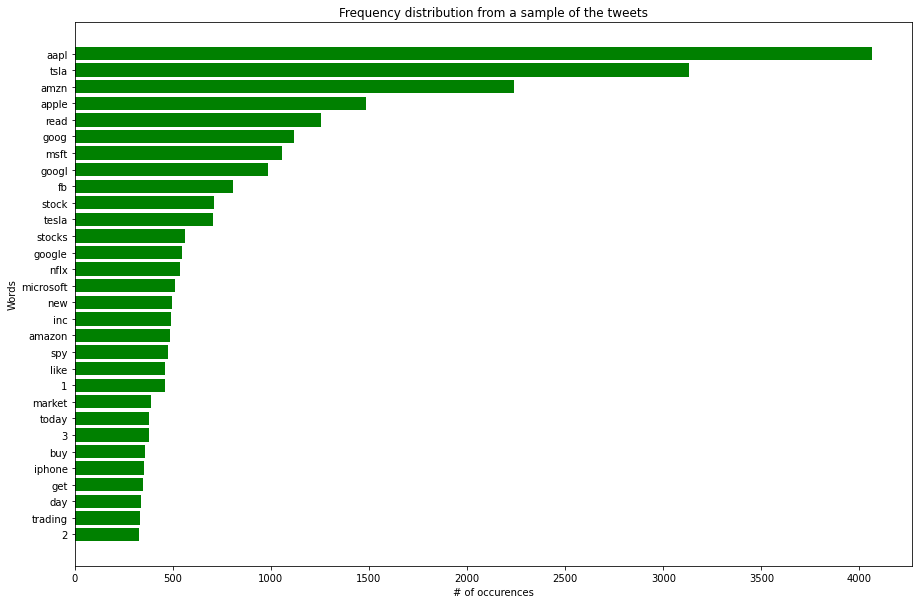

In [230]:
common_words = np.flip(common_words, axis=0)
bar_words = common_words[:, 0]
bar_occu = common_words[:, 1].astype(int)
bar_x = [i for i, _ in enumerate(bar_words)]

plt.figure(figsize=(15, 10))
plt.barh(bar_x, bar_occu, color='green')
plt.xlabel("# of occurences")
plt.ylabel("Words")
plt.title("Frequency distribution from a sample of the tweets")

plt.yticks(bar_x, bar_words)

plt.show()

The first 30 words consist mainly of companies' names and stock ticks as we can expect. But at the bottom there we can see words like \"like\" and "buy". This is very important, because they express some sort of sentiment.

### 4. Hypotheses

There are two main ways that social media could affect the market.
   1. The overall **amount of tweets** about a company raises the interest in its stocks, which results into more transactions being made (positions being closed and opened). The metric which tracks how much a stock is being traded is called **"Trading Volume"**. We can look for a correlation between the traded volume of a stock and how much people "talked" about it the previous day. 
       * The **null hypothesis** here is: There is *no correlation* between the amount of tweets about a company with the volume of its stock traded the following day.
       * And the **alternate hypothesis**: The *is a correlation* between the amount of tweets about a company with the volume of its stock traded the following day.


   2. Another important detail is what actually we're the people saying. In other words we would like to know if the general public opinion correlates in some way with the price's fluctuation. And what I mean by public opinion is whether the majority of the statements about a company made *online* are **positive or negative**. We will look at the correlation of the **average sentiment** of all tweets about a company and its **stock price** the following day.
       * **Null hypothesis**: There is *no correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.
       * And the **alternate hypothesis**: There *is a correlation* between the ratio of positive/negative tweets about a company with the price of its stock on the same day.

To test the our hypotheses we can use a correlation coefficient. The most common of these are the *Pearson correlation coefficient* and the *Spearman's rank correlation*. The first one is sensitive only to a linear relationship between two variables, which is not what we are looking for. The *Spearman's rank correlation coefficient* however is a lot more robust (sensitive to *non-linear relationships*) than Pearson's. That is why we will use it for this project.